In [ ]:
import torch as th
from torch import nn
import numpy as np
import random
import pandas as pd
#from torch.optim import Adam
from tqdm import tqdm
from torchvision.datasets import FashionMNIST
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt

# Загрузка данных

In [ ]:
df = FashionMNIST(root = '', download = True)

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting FashionMNIST/raw/train-images-idx3-ubyte.gz to FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting FashionMNIST/raw/train-labels-idx1-ubyte.gz to FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting FashionMNIST/raw/t10k-images-idx3-ubyte.gz to FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to FashionMNIST/raw



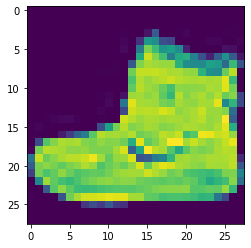

In [ ]:
plt.imshow(df[0][0])

In [ ]:
X = th.Tensor([np.array(i[0]) for i in df])
y = th.Tensor([i[1] for i in df])

<ipython-input-3-232d648f287e>:1: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:230.)
  X = th.Tensor([np.array(i[0]) for i in df])


In [ ]:
X_train = X[0:50000].reshape([-1, 28*28]).float()
y_train = y[0:50000].int()

X_test = X[50000:].reshape([-1, 28*28]).float()
y_test = y[50000:].int()

 Проверю трейн на баланс классов

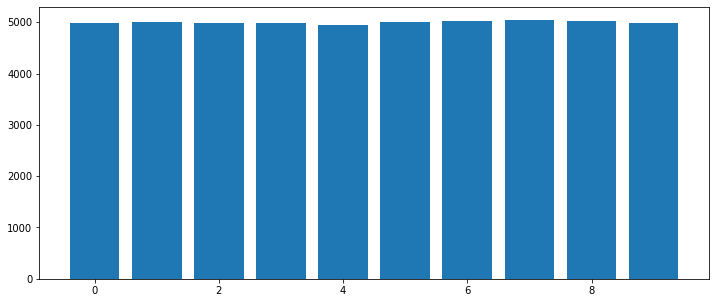

In [ ]:
fig, ax = plt.subplots()

ax.bar(np.arange(0, 10), pd.Series(y_train).value_counts().sort_index(ascending=True).tolist())


fig.set_figwidth(12) 
fig.set_figheight(5)  

plt.show()

# Полносвязная сеть

In [ ]:
class MNISTnet(th.nn.Module):
  def __init__(self):
    super (MNISTnet, self).__init__()
    self.fc1 = nn.Linear(784, 256)
    self.ac1 = nn.ReLU()
    self.fc2 = nn.Linear(256, 128)
    self.ac2 = nn.ReLU()
    self.fc3 = nn.Linear(128, 10)
    self.sm = nn.Softmax(dim = 1)


  def forward(self, x):
    x = self.fc1(x)
    x = self.ac1(x)
    x = self.fc2(x)
    x = self.ac2(x)
    x = self.fc3(x)
    return x


  def predict(self,x):
    x=self.forward(x)
    x=self.sm(x)
    return x

# Функция для обучения

In [ ]:
def init_fit_predict(opt: str, 
                     batch_size = 1000,
                     epochs = 50,
                     X_train = X_train,
                     y_train = y_train,
                     X_test = X_test,
                     y_test = y_test,
                     learning_rate = 0.01,
                     alpha = 0.90,
                     momentum = 0.3,
                     betas = (0.9, 0.99)):
  
    device = th.device('cuda:0' if th.cuda.is_available() else 'cpu')
    ###
    model = MNISTnet().to(device)
    loss_function = nn.CrossEntropyLoss()

    if opt == 'Adam':
        optimizer = th.optim.Adam(model.parameters(), lr = learning_rate, betas = betas)
    elif opt == 'RMSprop':
        optimizer = th.optim.RMSprop(model.parameters(), lr = learning_rate, alpha = alpha, momentum = momentum)
    elif opt == 'SGD':
        optimizer = th.optim.SGD(model.parameters(), lr = learning_rate)
    elif opt == 'SGD_momentum':
        optimizer = th.optim.SGD(model.parameters(), lr = learning_rate, momentum = momentum)
    elif opt == 'AdaGrad':
        optimizer = th.optim.Adagrad(model.parameters(), lr = learning_rate)
    elif opt == 'AdaMax':
        optimizer = th.optim.Adamax(model.parameters(), lr = learning_rate, betas = betas)
    elif opt == 'NAdam':
        optimizer = th.optim.NAdam(model.parameters(), lr = learning_rate, betas = betas)
    elif opt == 'SGD_Nesterov':
        optimizer = th.optim.SGD(model.parameters(), lr = learning_rate, momentum = momentum, nesterov = True)
          
    ###
    ###
    ###
    X_test = X_test.to(device)
    y_test = y_test.type(th.LongTensor).to(device)

    X_train = X_train.to(device)
    y_train = y_train.type(th.LongTensor).to(device)
    ###
    ###
    ###
    score = []
    for epoch in tqdm(range(epochs)):
        order = np.random.permutation(len(X_train))
        for start_index in range (0,len(X_train), batch_size):

            model.train() # перевод в режим train

            
            optimizer.zero_grad() # обнуляем градиенты

            batch_index = order[start_index:start_index+batch_size] # выделение батча из датасета
            X_batch = X_train[batch_index] #
            y_batch = y_train[batch_index] #

            preds = model.forward(X_batch) # предсказание на батче
            loss_val = loss_function(preds, y_batch) # лосс на батче

            loss_val.backward() # расчет градиентов
            optimizer.step() # шаг градиента + оптимизатора

        model.eval()
        score.append(f1_score(model.predict(X_test).to('cpu').argmax(dim = 1).tolist(), y_test.tolist(), average = 'weighted'))
    return score

# Тест оптимизаторов

## Adam

In [ ]:
adam = init_fit_predict(opt = 'Adam')

100%|██████████| 50/50 [00:05<00:00,  8.51it/s]


In [ ]:
adamax = init_fit_predict(opt = 'AdaMax')

100%|██████████| 50/50 [00:06<00:00,  7.94it/s]


In [ ]:
NAdam = init_fit_predict(opt = 'NAdam')

100%|██████████| 50/50 [00:06<00:00,  7.96it/s]


In [ ]:
rmsprop = init_fit_predict(opt = 'RMSprop')

100%|██████████| 50/50 [00:04<00:00, 10.35it/s]


In [ ]:
adagrad = init_fit_predict(opt = 'AdaGrad')

100%|██████████| 50/50 [00:06<00:00,  8.24it/s]


In [ ]:
sgd = init_fit_predict(opt = 'SGD', learning_rate = 0.5)

100%|██████████| 50/50 [00:04<00:00, 10.07it/s]


In [ ]:
sgd_momentum = init_fit_predict(opt = 'SGD_momentum', momentum = 0.5, learning_rate = 0.5)

100%|██████████| 50/50 [00:04<00:00, 12.02it/s]


In [ ]:
sgd_nesterov = init_fit_predict(opt = 'SGD_Nesterov', momentum = 0.5, learning_rate = 0.5)

100%|██████████| 50/50 [00:04<00:00, 11.12it/s]


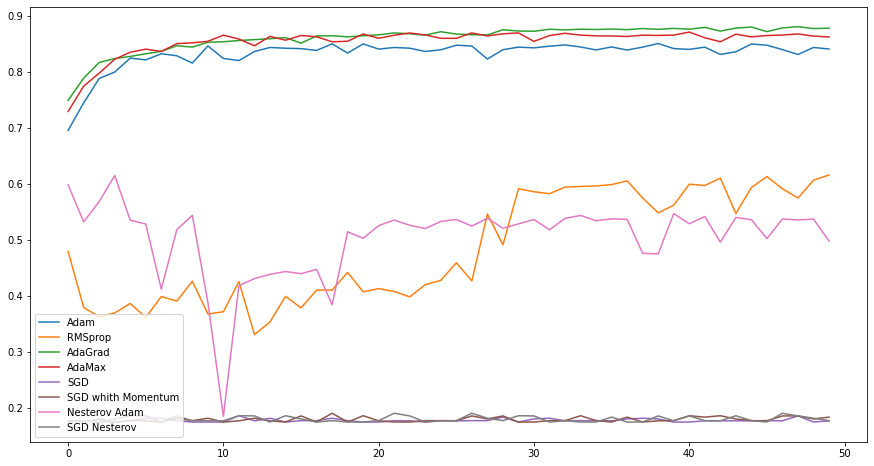

In [ ]:
fig, ax = plt.subplots()
#
ax.plot(adam, label = 'Adam')
ax.plot(rmsprop, label = 'RMSprop')
ax.plot(adagrad, label = 'AdaGrad')
ax.plot(adamax, label = 'AdaMax')
ax.plot(sgd, label = 'SGD')
ax.plot(sgd_momentum, label = 'SGD whith Momentum')
ax.plot(NAdam, label = 'Nesterov Adam')
ax.plot(sgd_nesterov, label = 'SGD Nesterov')
#
ax.legend(loc = 3)
#
fig.set_figwidth(15) 
fig.set_figheight(8)  

In [ ]:
result = pd.DataFrame({'Adam': [5, adam[-1]],
                       'RMSprop': [4, rmsprop[-1]],
                       'AdaGrad': [6, adagrad[-1]],
                       'AdaMax': [6, adamax[-1]],
                       'SGD': [4, sgd[-1]],
                       'SGD_Momentum': [4, sgd_momentum[-1]],
                       'NesterovAdam': [6, NAdam[-1]],
                       'SGD_Nesterov': [4, sgd_nesterov[-1]]},
                      index = ['time', 'score'])

In [ ]:
result

,Adam,RMSprop,AdaGrad,AdaMax,SGD,SGD_Momentum,NesterovAdam,SGD_Nesterov
time,5.0000,4.00000,6.000000,6.000000,4.000000,4.00000,6.000000,4.000000
score,0.8409,0.61579,0.878136,0.862395,0.176513,0.18314,0.497822,0.176846


# Реализация EMA

In [ ]:
d = [14, 16.7, 16.6, 16.5, 16.2]

In [ ]:
def ema(x, b):
    x.insert(0, 0)
    res = []
    for i in range(1, len(x)):
        res.append(round(x[i - 1] * b + (1 - b) * x[i], 2))
    res.insert(0, 0)
    return res

In [ ]:
y = ema(b = 0.73, x = d)

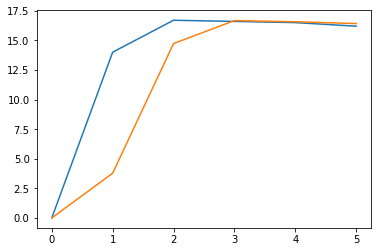

In [ ]:
plt.plot(d)
plt.plot(y)